<a href="https://colab.research.google.com/github/kvelez-iastate/S2021_ME592/blob/project/02_%7C_1_Layer_LSTM_%7C_18_Datapoints_%7C_1_File_%7C_1_Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Input

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/ME592/Project', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [ ]:
#%%

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
#%%

path = r'/content/mnt/My Drive/Colab Notebooks/ME592/Project/NASA_TurboData/CMaps'
# path = r'C:\Users\ks07142\OneDrive-Deere&Co\OneDrive - Deere & Co\Graduate School\Spring2021_ME592\Project\NASA_TurboData\CMaps'

# loop through sub-directories and make a list of the paths to all data files
file_paths = []
for root, dirs, files in os.walk(path, topdown = True):
   for name in files:
      file_paths.append(os.path.join(root, name))


# Group Test data
test_data = []
for i in range(len(file_paths)):
  if 'test' in file_paths[i]:
    test_data.append(file_paths[i])
test_data = sorted(test_data)

# Group Train data
train_data = []
for i in range(len(file_paths)):
  if 'train' in file_paths[i]:
    train_data.append(file_paths[i])
train_data = sorted(train_data)

# Group Remaining Useful Life (RUL) data
rul_data = []
for i in range(len(file_paths)):
  if 'RUL' in file_paths[i]:
    rul_data.append(file_paths[i])
rul_data = sorted(rul_data)

# initialize normalization scale factors
input_scale = preprocessing.MinMaxScaler()
rul_scale = preprocessing.MinMaxScaler()

# initialize training lists
traindata_list = []
alltrainunitdata_list = []
alltrainunitdata_scaled_list = []
trainfailurecycle_list = []
trainingunit_list = []

files = 1

# run through each of the 4 training files
for i in range(files):
    
    # read in training data, one file at a time
    train = pd.read_csv(train_data[i],delimiter=' ',header=None)
    
    # initialize starting index for each unit collection
    startindex = 0
    
    # initialize list of unit data, this will seperate out each file into a 
    # seperate entry in a list
    unitdata_list = []
    
    # run through an individual training file to pull out groups of unit data
    for k in range(len(train)-1):
        
        # check the unit number of the next line, if they are different then 
        # this k value represents the end of a grouping of units
        if train.iloc[k,0] != train.iloc[k+1,0]:
            # the last index in the unit group
            endindex = k
            
            # all of the data in the unit group, as defined by the start and
            # end index values
            unitdata = train.iloc[startindex:endindex,:]
            # drop columns with NA values
            unitdata.dropna(axis=1,how='all',inplace=True)
            # add unit number to list before dropping
            trainingunit_list.append(unitdata.iloc[0,0])  
            # drop unit number as it isn't relevant to predictions
            unitdata = unitdata.iloc[:,1:]
            # drop uncorrelated columns
            unitdata.drop(unitdata.columns[[3,4,8,13,19,21,22]],axis=1,inplace=True)

            # scale values
            # unitdata_scaled = input_scale.fit_transform(unitdata)
            unitdata_cycles = unitdata.iloc[:,0].to_numpy()
            unitdata_scaled = input_scale.fit_transform(unitdata.iloc[:,1:])
            unitdata_scaled = np.column_stack((unitdata_cycles,unitdata_scaled))

            # in the training data, we assume it failed during the last cycle
            failurecycle = train.iloc[endindex,1]
            
            # update the starting index to the next unit group
            startindex = endindex + 1
            
            # append to lists
            trainfailurecycle_list.append(failurecycle)
            unitdata_list.append(unitdata)
            alltrainunitdata_list.append(unitdata)
            alltrainunitdata_scaled_list.append(unitdata_scaled)

        elif k == len(train)-2:
            # the last index in the unit group
            endindex = k
            
            # all of the data in the unit group, as defined by the start and
            # end index values
            unitdata = train.iloc[startindex:endindex,:]
            # drop columns with NA values
            unitdata.dropna(axis=1,how='all',inplace=True)
            # add unit number to list before dropping
            trainingunit_list.append(unitdata.iloc[0,0])
            # drop unit number as it isn't relevant to predictions
            unitdata = unitdata.iloc[:,1:]
            # drop uncorrelated columns
            unitdata.drop(unitdata.columns[[3,4,8,13,19,21,22]],axis=1,inplace=True)
            
            # scale values
            unitdata_cycles = unitdata.iloc[:,0].to_numpy()
            unitdata_scaled = input_scale.fit_transform(unitdata.iloc[:,1:])
            unitdata_scaled = np.column_stack((unitdata_cycles,unitdata_scaled))
            # in the training data, we assume it failed during the last cycle
            failurecycle = train.iloc[endindex,1]
            
            # update the starting index to the next unit group
            startindex = endindex + 1
            
            # append to lists
            trainfailurecycle_list.append(failurecycle)
            unitdata_list.append(unitdata)
            alltrainunitdata_list.append(unitdata)
            alltrainunitdata_scaled_list.append(unitdata_scaled)
            
            
    # append to list where each item is for a different file
    traindata_list.append(unitdata_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to b

Text(0.5, 1.0, 'Training Set Failures')

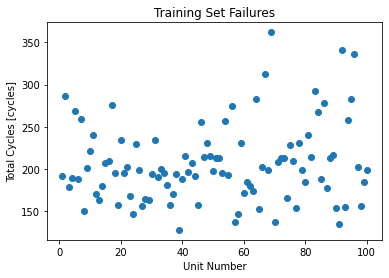

In [ ]:
trainingunit_np = np.array(trainingunit_list)
trainfailurecycle_np = np.array(trainfailurecycle_list)

plt.figure()
plt.scatter(trainingunit_np,trainfailurecycle_np)
# plt.scatter(unit_np,rul_np)
plt.ylabel('Total Cycles [cycles]')
plt.xlabel('Unit Number')
plt.title('Training Set Failures')
# plt.legend(('Prediction','Actual'))

## Model Training

In [ ]:
#%% 
# sort into grouping of data with specified number of rows

datapoints = 18

groupedtrainData_list = []

for j in range(len(alltrainunitdata_scaled_list)):
    # pull out a single dataset from the training data
    dataset = alltrainunitdata_scaled_list[j]
    # pull out the number of cycles for failure of that training dataset
    failurecycle = trainfailurecycle_list[j]
    
    # for each set of trainin data, group the data into datapoint number of rows
    # and attach the failure cycle to end
    for i in range(len(dataset)-datapoints+1):
        # RUL calculation
        RULentry = failurecycle - (i+datapoints)
        # select number of datapoints from training data
        groupedDataset = dataset[i:(i+datapoints),:]
        # make a list of the grouped data and the failures to cycle it should predict
        groupedData_entry = [groupedDataset,RULentry]
        # put all the data into a list
        groupedtrainData_list.append(groupedData_entry)


### 100 LSTM, Linear

In [ ]:
#%%

# neural network parameters
learning_rate = 0.001
hiddenlayers = 100
n_folds = 5

class MLModel(nn.Module):
    def __init__(self, input_size=18, hidden_layer_size=hiddenlayers, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


### 5 kfolds

In [ ]:
#%%

model = MLModel()
model = model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
k_fold = KFold(n_splits = n_folds, shuffle=False)

# covnert list to np array
groupedtrainData_np = np.array(groupedtrainData_list)

# Collect kfold loss to plot later
kfold_singleloss_list = []

for train_index, validate_index in k_fold.split(groupedtrainData_np):
    trainfold = groupedtrainData_np[train_index]
    traininput = trainfold[:,0]
    trainoutput = trainfold[:,1]
    
    validatefold = groupedtrainData_np[validate_index]
    validateinput = validatefold[:,0]
    validateoutput = validatefold[:,1]

    singleloss_list = []

    for k in range(len(trainfold)):
        traininput_tensor = torch.tensor(traininput[k]).float()
        trainoutput_tensor = torch.tensor(trainoutput[k]).float()

        traininput_tensor = traininput_tensor
        trainoutput_tensor = trainoutput_tensor
        
        foldloss = 0
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                      torch.zeros(1, 1, model.hidden_layer_size).cuda())
        
        y_pred = model(traininput_tensor.cuda())
        single_loss = loss_function(y_pred, trainoutput_tensor.cuda())
        single_loss.backward()
        optimizer.step()
        
        singleloss_list.append(single_loss)

        if k % 10000 == 0:
            text1 = 'Step: {} of {}, Predicted value: {}, Actual Value: {}'.format(k, len(trainfold), y_pred.detach().cpu().numpy(),trainoutput_tensor)
            print(text1)
            text = 'Loss is {}'.format(single_loss)
            print(text)
            
    kfold_singleloss_list.append(singleloss_list)
    
    for i in range(len(validatefold)):
        validateinput_tensor = torch.tensor(validateinput[i]).float()
        validateoutput_tensor = torch.tensor(validateoutput[i]).float()

        validateinput_tensor = validateinput_tensor.cuda()
        validateoutput_tensor = validateoutput_tensor.cuda()
        
        y_pred_validate = model(validateinput_tensor)
        validate_loss = loss_function(y_pred_validate, validateoutput_tensor)
    
        foldloss += validate_loss

    text2 = 'Fold error is {}'.format(foldloss/len(validatefold))
    print('-----------')
    print(text2)
    print('-----------')
        
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step: 0 of 15064, Predicted value: [0.0325487], Actual Value: 42.0
Loss is 1761.26708984375
Step: 10000 of 15064, Predicted value: [42.474926], Actual Value: 43.0
Loss is 0.27570271492004395
-----------
Fold error is 1854.005615234375
-----------
Step: 0 of 15064, Predicted value: [138.64417], Actual Value: 174.0
Loss is 1250.0350341796875
Step: 10000 of 15064, Predicted value: [69.29339], Actual Value: 43.0
Loss is 691.34228515625
-----------
Fold error is 832.4852905273438
-----------
Step: 0 of 15064, Predicted value: [138.35075], Actual Value: 174.0
Loss is 1270.8687744140625
Step: 10000 of 15064, Predicted value: [45.05923], Actual Value: 43.0
Loss is 4.240431308746338
-----------
Fold error is 1256.183837890625
-----------
Step: 0 of 15064, Predicted value: [137.5438], Actual Value: 174.0
Loss is 1329.0550537109375
Step: 10000 of 15064, Predicted value: [151.00717], Actual Value: 247.0
Loss is 9214.623046875
-----------
Fold error is 2834.49755859375
-----------
Step: 0 of 15064,

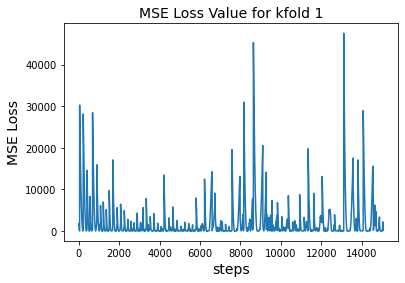

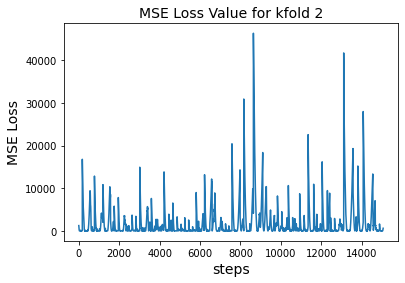

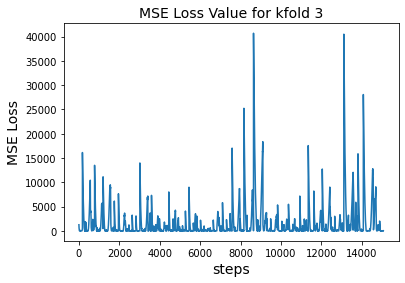

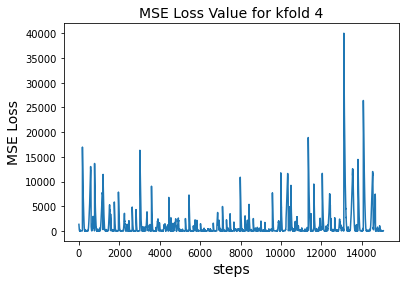

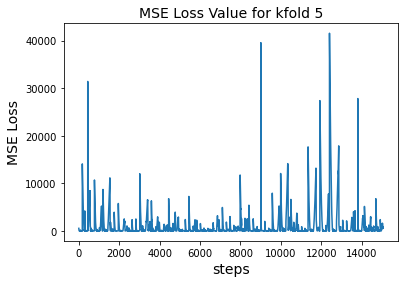

In [ ]:
for i in range(5):

  x = range(len(kfold_singleloss_list[i]))
  y = kfold_singleloss_list[i]

  plt.figure()
  plt.plot(x,y)
  plt.title('MSE Loss Value for kfold {}'.format(i+1),size=14)
  plt.xlabel('steps',size=14)
  plt.ylabel('MSE Loss',size=14)

## Test

In [ ]:
# initialize testing lists
testdata_list = []
alltestunitdata_list = []
alltestunitdata_scaled_list = []
testfailurecycle_list = []
unit_list = []
rul_list = []

# run through each of the 4 testing files
for i in range(files):
    
    # read in testing data, one file at a time
    test = pd.read_csv(test_data[i],delimiter=' ',header=None)
    rul = pd.read_csv(rul_data[i],delimiter=' ',header=None)
    
    # drop NA in RUL data
    rul.dropna(axis=1,how='all',inplace=True)
    
    # initialize starting index for each unit collection
    startindex = 0
    
    # initialize list of unit data, this will seperate out each file into a 
    # seperate entry in a list
    unitdata_list = []
    
    unitnumber = 0
    
    # run through an individual testing file to pull out groups of unit data
    for k in range(len(test)-1):
        
        # check the unit number of the next line, if they are different then 
        # this k value represents the end of a grouping of units
        if test.iloc[k,0] != test.iloc[k+1,0]:
            # the last index in the unit group
            endindex = k
            
            # all of the data in the unit group, as defined by the start and
            # end index values
            unitdata = test.iloc[startindex:endindex,:]
            # drop columns with NA values
            unitdata.dropna(axis=1,how='all',inplace=True)
            # add unit number to list before dropping
            unit_list.append(unitdata.iloc[0,0])            
            # drop unit number as it isn't relevant to predictions
            unitdata = unitdata.iloc[:,1:]
            # drop uncorrelated columns
            unitdata.drop(unitdata.columns[[3,4,8,13,19,21,22]],axis=1,inplace=True)

            # scale values
            unitdata_cycles = unitdata.iloc[:,0].to_numpy()
            unitdata_scaled = input_scale.fit_transform(unitdata.iloc[:,1:])
            unitdata_scaled = np.column_stack((unitdata_cycles,unitdata_scaled))
            
            # in the testing data, we assume it failed during the last cycle
            failurecycle = rul.iloc[unitnumber] + unitdata_cycles[-1]
            rul_list.append(rul.iloc[unitnumber].to_numpy())
            
            # update the starting index to the next unit group
            startindex = endindex + 1
            
            # append to lists
            testfailurecycle_list.append(failurecycle.values)
            unitdata_list.append(unitdata)
            alltestunitdata_list.append(unitdata)
            alltestunitdata_scaled_list.append(unitdata_scaled)
            
            unitnumber += 1
            
        # collecting the last unit of the dataset    
        elif k == len(test)-2:
            # the last index in the unit group
            endindex = k
            
            # all of the data in the unit group, as defined by the start and
            # end index values
            unitdata = test.iloc[startindex:endindex,:]
            # drop columns with NA values
            unitdata.dropna(axis=1,how='all',inplace=True)
            # add unit number to list before dropping
            unit_list.append(unitdata.iloc[0,0]) 
            # drop unit number as it isn't relevant to predictions
            unitdata = unitdata.iloc[:,1:]
            # drop uncorrelated columns
            unitdata.drop(unitdata.columns[[3,4,8,13,19,21,22]],axis=1,inplace=True)
            
            # scale values
            unitdata_cycles = unitdata.iloc[:,0].to_numpy()
            unitdata_scaled = input_scale.fit_transform(unitdata.iloc[:,1:])
            unitdata_scaled = np.column_stack((unitdata_cycles,unitdata_scaled))
            
            # in the testing data, we assume it failed during the last cycle
            failurecycle = rul.iloc[unitnumber] + unitdata_cycles[-1]
            rul_list.append(rul.iloc[unitnumber].to_numpy())
            
            # update the starting index to the next unit group
            startindex = endindex + 1
            
            # append to lists
            testfailurecycle_list.append(failurecycle.values)
            unitdata_list.append(unitdata)
            alltestunitdata_list.append(unitdata)
            alltestunitdata_scaled_list.append(unitdata_scaled)
            
            unitnumber += 1
            
            
            
    # append to list where each item is for a different file
    testdata_list.append(unitdata_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
datapoints = 18

groupedtestData_list = []
test_predict_list = []
predictions_list = []

for j in range(len(alltestunitdata_scaled_list)):
    # pull out a single dataset from the training data
    dataset = alltestunitdata_scaled_list[j]
    # pull out the number of cycles for failure of that training dataset
    failurecycle = testfailurecycle_list[j]
    
    predictions = []
    # for each set of trainin data, group the data into datapoint number of rows
    # and attach the failure cycle to end
    for i in range(len(dataset)-datapoints+1):
        # RUL calculation
        RULentry = failurecycle - (i+datapoints)
        # select number of datapoints from training data
        groupedDataset = dataset[i:(i+datapoints),:]
        # make a list of the grouped data and the failures to cycle it should predict
        groupedData_entry = [groupedDataset,RULentry]
        # put all the data into a list
        groupedtestData_list.append(groupedData_entry)
        
        test_tensor = torch.tensor(groupedDataset).float()

        test_predict = model(test_tensor.cuda())

        predictions.append(test_predict.detach().cpu().numpy())
    
    test_singleprediction = predictions[-1]
    test_predict_list.append(test_singleprediction)
    predictions_list.append(predictions)

    # print('Prediction: {}, RUL: {}'.format(test_singleprediction,failurecycle))

In [ ]:
for i in range(len(predictions_list)):
  print(rul_list[i])
  print(predictions_list[i])

[112]
[array([144.66379], dtype=float32), array([144.66258], dtype=float32), array([144.66266], dtype=float32), array([144.6631], dtype=float32), array([144.66043], dtype=float32), array([144.66226], dtype=float32), array([144.66127], dtype=float32), array([144.66087], dtype=float32), array([144.66014], dtype=float32), array([144.65881], dtype=float32), array([144.65997], dtype=float32), array([144.65913], dtype=float32), array([144.65912], dtype=float32)]
[98]
[array([144.66304], dtype=float32), array([144.66296], dtype=float32), array([144.66342], dtype=float32), array([144.6619], dtype=float32), array([144.66263], dtype=float32), array([144.66278], dtype=float32), array([144.66219], dtype=float32), array([144.6608], dtype=float32), array([144.65942], dtype=float32), array([144.66103], dtype=float32), array([144.65732], dtype=float32), array([144.65508], dtype=float32), array([144.65916], dtype=float32), array([144.6567], dtype=float32), array([144.65985], dtype=float32), array([144.

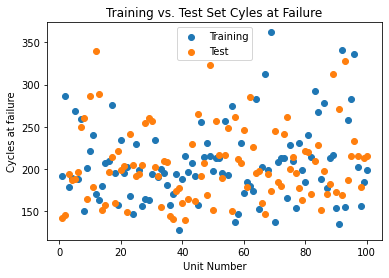

In [ ]:
trainingunit_np = np.array(trainingunit_list)
trainfailurecycle_np = np.array(trainfailurecycle_list)
unit_np = np.array(unit_list)
testfailurecycle_np = np.array(testfailurecycle_list)

plt.figure()
plt.scatter(trainingunit_np,trainfailurecycle_np)
plt.scatter(unit_np,testfailurecycle_np)
plt.ylabel('Cycles at failure')
plt.xlabel('Unit Number')
plt.title('Training vs. Test Set Cyles at Failure')
plt.legend(('Training','Test'))

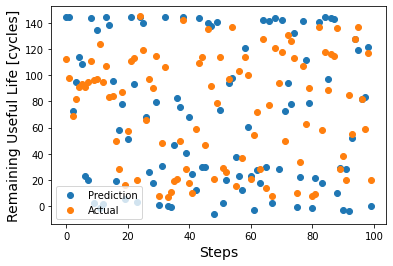

In [ ]:
step_np = range(len(test_predict_list))
test_predict_np = np.array(test_predict_list)
testfailurecycle_np = np.array(testfailurecycle_list)
RUL_np = np.array(rul_list)

plt.figure()
plt.scatter(step_np,test_predict_np)
plt.scatter(step_np,RUL_np)
plt.ylabel('Remaining Useful Life [cycles]',size=14)
plt.xlabel('Steps',size=14)
plt.legend(('Prediction','Actual'))
plt.rcParams["figure.figsize"] = (10,6)

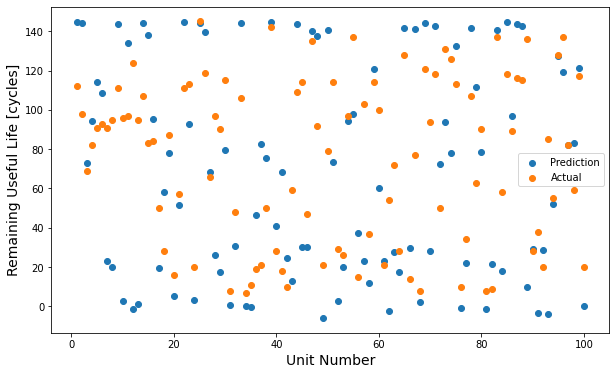

In [ ]:
unit_np = np.array(unit_list)
test_predict_np = np.array(test_predict_list)
testfailurecycle_np = np.array(testfailurecycle_list)

plt.figure()
plt.scatter(unit_np,test_predict_np)
plt.scatter(unit_np,RUL_np)
plt.ylabel('Remaining Useful Life [cycles]',size=14)
plt.xlabel('Unit Number',size=14)
plt.legend(('Prediction','Actual'))